In [ ]:
# Importamos las bibliotecas necesarias para trabajar con JAX y datos
import jax
import jax.numpy as jnp
from datetime import datetime
import numpy as np  # para interoperabilidad y carga de datos
import matplotlib.pyplot as plt
import pandas as pd

# Verificamos que JAX esté funcionando y en qué dispositivo se ejecuta
print("JAX version:", jax.__version__)
print("JAX running on:", jax.devices()[0])


JAX version: 0.5.2
JAX running on: TFRT_CPU_0


 # Construir pipelines en JAX

JAX es una librería de Google que permite hacer computación numérica eficiente y diferenciación automática. Su API es muy parecida a la de NumPy, pero con soporte para aceleradores como GPUs y TPUs

Creación de datos base

In [ ]:
# Creamos un array de ejemplo usando JAX
array_examp = jnp.arange(70).reshape((7, 10))
lista_examp = np.array(array_examp).tolist()  # Convertimos a lista de Python si es necesario
print(array_examp.shape)


(7, 10)


JAX provee su propia versión de arange y reshape, igual que NumPy. Pero si necesitamos interoperar con listas nativas de Python, debemos convertir usando np.array(...)

Dataset API

In [ ]:
# En JAX no existe una API oficial para datasets como en TensorFlow.
# Podemos usar generadores o manejar manualmente los lotes con slicing.

def dataset_from_tensor_slices(data):
    # Simula la funcionalidad de tf.data.Dataset.from_tensor_slices
    for i in range(data.shape[0]):
        yield data[i]

dataset1 = dataset_from_tensor_slices(array_examp)

# from_tensors sería simplemente devolver el tensor completo
dataset2 = array_examp

# Si quisiéramos usar listas, podríamos convertirlas a arrays:
dataset_lista_1 = dataset_from_tensor_slices(jnp.array(lista_examp))
dataset_lista_2 = jnp.array(lista_examp)


En lugar de usar un sistema complejo de datasets, en JAX trabajamos con estructuras de datos más explícitas, como generadores o iteradores sobre arrays

Dataset con tuplas de tensores

In [ ]:
# Creamos dos tensores de ejemplo con jax.numpy
tensor1 = jnp.ones((10, 2, 2))
tensor2 = jnp.ones((10, 1))

# Simulamos tf.data.Dataset.from_tensor_slices para tuplas
def dataset_from_slices_tuple(t1, t2):
    for i in range(t1.shape[0]):
        yield t1[i], t2[i]

dataset3 = dataset_from_slices_tuple(tensor1, tensor2)


Cuando queremos recorrer dos arrays simultáneamente como pares (como en TensorFlow), simplemente iteramos por índice y usamos yield para devolver una tupla.

In [ ]:
tensor3 = jnp.ones((9, 2, 2))

# Intentar emparejar tensores de distinta longitud genera error.
# Aquí lo mostramos con control de errores.
try:
    dataset4 = dataset_from_slices_tuple(tensor1, tensor3)
except Exception as e:
    print("Error al crear dataset4:", e)


En JAX (y en general en Python), emparejar arrays de distinta longitud requiere manejar explícitamente los errores. A diferencia de TensorFlow, no hay una abstracción que lo oculte.

Dataset con from_tensors (todo el tensor como un solo ejemplo)

In [ ]:
# Equivalente a almacenar la tupla completa como un solo elemento
dataset5 = [(tensor1, tensor2)]
dataset6 = [(tensor1, tensor3)]  # Nota: aunque tengan distintas formas, se acepta en Python


In [ ]:
# Volvemos a definir dataset1 y dataset2 como generadores
dataset1 = dataset_from_tensor_slices(array_examp)
dataset2 = dataset_from_tensor_slices(array_examp)

# Zip de datasets (generadores en Python)
dataset3 = zip(dataset1, dataset2)

# Iteramos e imprimimos las formas
for a, b in dataset3:
    print(f'shapes: {a.shape}, {b.shape}')


shapes: (10,), (10,)
shapes: (10,), (10,)
shapes: (10,), (10,)
shapes: (10,), (10,)
shapes: (10,), (10,)
shapes: (10,), (10,)
shapes: (10,), (10,)


La función zip de Python cumple la misma función que tf.data.Dataset.zip. Al usar generadores, se recorren en paralelo los elementos.

### Iteracion

In [ ]:
# dataset1 ya es un generador en nuestra versión
# Como JAX usa arrays inmutables, los elementos ya son arrays de NumPy-compatible

dataset1 = dataset_from_tensor_slices(array_examp)
for elem in dataset1:
    print(np.array(elem))  # Convertimos a NumPy para imprimir si es necesario


[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]
[50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69]


Aunque jnp.array se parece a np.array, su contenido puede necesitar conversión explícita a NumPy para usar ciertas funciones de visualización o impresión.

### Enumerar

In [ ]:
from itertools import count

dataset1 = dataset_from_tensor_slices(array_examp)
dataset_enu = zip(count(start=5), dataset1)

for index, element in dataset_enu:
    print((index, np.array(element)))


(5, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32))
(6, array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32))
(7, array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32))
(8, array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39], dtype=int32))
(9, array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49], dtype=int32))
(10, array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int32))
(11, array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69], dtype=int32))


En Python usamos itertools.count(start=N) para obtener una enumeración manual como la que ofrece TensorFlow con .enumerate().

### Barajar

Shuffle y repetición

In [ ]:
import random

# Convertimos a lista para poder mezclar y repetir
data_list = list(array_examp)

# Simulamos barajado + repetición
repeat_count = 4
shuffled_repeated_data = []

for _ in range(repeat_count):
    batch = data_list.copy()
    random.shuffle(batch)
    shuffled_repeated_data.extend(batch)

# Ahora podemos iterar sobre esto
for element in shuffled_repeated_data:
    print(element)


[50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69]
[20 21 22 23 24 25 26 27 28 29]
[10 11 12 13 14 15 16 17 18 19]
[40 41 42 43 44 45 46 47 48 49]
[0 1 2 3 4 5 6 7 8 9]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]
[0 1 2 3 4 5 6 7 8 9]
[50 51 52 53 54 55 56 57 58 59]
[10 11 12 13 14 15 16 17 18 19]
[60 61 62 63 64 65 66 67 68 69]
[30 31 32 33 34 35 36 37 38 39]
[20 21 22 23 24 25 26 27 28 29]
[50 51 52 53 54 55 56 57 58 59]
[40 41 42 43 44 45 46 47 48 49]
[0 1 2 3 4 5 6 7 8 9]
[30 31 32 33 34 35 36 37 38 39]
[60 61 62 63 64 65 66 67 68 69]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[10 11 12 13 14 15 16 17 18 19]
[60 61 62 63 64 65 66 67 68 69]
[0 1 2 3 4 5 6 7 8 9]
[20 21 22 23 24 25 26 27 28 29]
[40 41 42 43 44 45 46 47 48 49]
[30 31 32 33 34 35 36 37 38 39]
[50 51 52 53 54 55 56 57 58 59]


En JAX usamos Python estándar para manipular datos: random.shuffle para barajar y ciclos para repetir. Esta forma es más explícita y controlada.

### Batch

Dataset de rango + batching + enumerate

In [ ]:
# Creamos un rango del 0 al 19
data = jnp.arange(20)

# Agrupamos en batches de 3
batch_size = 3
batches = [data[i:i+batch_size] for i in range(0, len(data), batch_size)]

# Enumeramos los batches
for idx, batch in enumerate(batches):
    print((idx, np.array(batch)))


(0, array([0, 1, 2], dtype=int32))
(1, array([3, 4, 5], dtype=int32))
(2, array([6, 7, 8], dtype=int32))
(3, array([ 9, 10, 11], dtype=int32))
(4, array([12, 13, 14], dtype=int32))
(5, array([15, 16, 17], dtype=int32))
(6, array([18, 19], dtype=int32))


El batching se puede implementar fácilmente dividiendo el array en secciones. Enumerar luego es directo usando enumerate.

In [ ]:
# Igual que antes, pero excluimos el último batch si no está completo
batch_size = 3
total_size = len(data) - (len(data) % batch_size)  # descartar elementos sobrantes
batches = [data[i:i+batch_size] for i in range(0, total_size, batch_size)]

for idx, batch in enumerate(batches):
    print((idx, np.array(batch)))


(0, array([0, 1, 2], dtype=int32))
(1, array([3, 4, 5], dtype=int32))
(2, array([6, 7, 8], dtype=int32))
(3, array([ 9, 10, 11], dtype=int32))
(4, array([12, 13, 14], dtype=int32))
(5, array([15, 16, 17], dtype=int32))


Cuando drop_remainder=True, descartamos los últimos elementos que no llenen un batch completo.

Método .take(n)

In [ ]:
# Suponemos que 'batches' está definido como en las celdas anteriores
for element in batches[:2]:  # Simula take(2)
    print(element)


[0 1 2]
[3 4 5]


El método take(n) de TensorFlow puede reemplazarse directamente con slicing en Python: [:n].

Enumerar dataset batcheado

In [ ]:
# Creamos batches de tamaño 3
dataset1 = dataset_from_tensor_slices(array_examp)
dataset1_list = list(dataset1)
batches = [dataset1_list[i:i+3] for i in range(0, len(dataset1_list), 3)]

# Enumeramos los batches
for idx, batch in enumerate(batches):
    print((idx, np.array(batch)))


(0, array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]], dtype=int32))
(1, array([[30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]], dtype=int32))
(2, array([[60, 61, 62, 63, 64, 65, 66, 67, 68, 69]], dtype=int32))


Los datasets de JAX pueden batchearse fácilmente dividiendo listas en bloques. El enumerate es estándar de Python.

Batching con tamaño 1

In [ ]:
batches_1 = [dataset1_list[i:i+1] for i in range(0, len(dataset1_list))]

for idx, batch in enumerate(batches_1):
    print((idx, np.array(batch)))


(0, array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=int32))
(1, array([[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]], dtype=int32))
(2, array([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]], dtype=int32))
(3, array([[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]], dtype=int32))
(4, array([[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]], dtype=int32))
(5, array([[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]], dtype=int32))
(6, array([[60, 61, 62, 63, 64, 65, 66, 67, 68, 69]], dtype=int32))


Este patrón es útil para trabajar con un solo ejemplo por paso (por ejemplo, en entrenamiento online o por pasos).

### funcion map

Función de preprocesamiento: pasos densos

In [ ]:
# Simula un paso temporal en que las etiquetas son la siguiente observación
def dense_1_step(batch):
    return batch[:-1], batch[1:]


Esta función es útil para crear pares de entrada/salida secuenciales. Muy común en modelos de predicción temporal o de lenguaje.



Aplicar transformación con .map()

In [ ]:
# Aplicamos la función dense_1_step a cada batch (aquí, sobre array_examp como un solo batch)
features, labels = dense_1_step(array_examp)

# Mostramos los resultados
for f, l in zip(features, labels):
    print(np.array(f), " => ", np.array(l))


[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14 15 16 17 18 19]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22 23 24 25 26 27 28 29]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32 33 34 35 36 37 38 39]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44 45 46 47 48 49]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52 53 54 55 56 57 58 59]
[50 51 52 53 54 55 56 57 58 59]  =>  [60 61 62 63 64 65 66 67 68 69]


TensorFlow permite transformar datasets con .map(). En JAX, aplicamos la transformación directamente a arrays o listas. Si estamos trabajando en lotes, usamos ciclos o list comprehensions.

### funcion flat_map

In [ ]:
# dataset1 es un generador que recorre filas del array_examp
dataset1 = dataset_from_tensor_slices(array_examp)

# Aplicamos flat_map: para cada elemento (que es un array 1D), generamos múltiples elementos (uno por item)
def flat_map(generator, fn):
    for x in generator:
        for y in fn(x):
            yield y

# Definimos la función que convierte un vector en elementos individuales
def from_tensor_slices(x):
    return x  # x ya es un array 1D; iterarlo da sus elementos

# Aplicamos flat_map
flat_mapped = flat_map(dataset1, from_tensor_slices)

# Lo convertimos a lista y mostramos
flat_mapped_list = list(flat_mapped)
print(flat_mapped_list)


[Array(0, dtype=int32), Array(1, dtype=int32), Array(2, dtype=int32), Array(3, dtype=int32), Array(4, dtype=int32), Array(5, dtype=int32), Array(6, dtype=int32), Array(7, dtype=int32), Array(8, dtype=int32), Array(9, dtype=int32), Array(10, dtype=int32), Array(11, dtype=int32), Array(12, dtype=int32), Array(13, dtype=int32), Array(14, dtype=int32), Array(15, dtype=int32), Array(16, dtype=int32), Array(17, dtype=int32), Array(18, dtype=int32), Array(19, dtype=int32), Array(20, dtype=int32), Array(21, dtype=int32), Array(22, dtype=int32), Array(23, dtype=int32), Array(24, dtype=int32), Array(25, dtype=int32), Array(26, dtype=int32), Array(27, dtype=int32), Array(28, dtype=int32), Array(29, dtype=int32), Array(30, dtype=int32), Array(31, dtype=int32), Array(32, dtype=int32), Array(33, dtype=int32), Array(34, dtype=int32), Array(35, dtype=int32), Array(36, dtype=int32), Array(37, dtype=int32), Array(38, dtype=int32), Array(39, dtype=int32), Array(40, dtype=int32), Array(41, dtype=int32), A

flat_map permite aplicar una función que devuelve múltiples elementos por entrada, y luego aplana todo en un solo flujo. En Python lo hacemos con generadores anidados.

### Dataset como texto .txt

 Leer y preprocesar un archivo de texto

In [ ]:
# Leemos el archivo como texto plano
with open('sonnets.txt', 'r', encoding='utf-8') as file:
    text_string = file.read().replace('\n', ' ')

print(text_string[:500])


	SONNETS    TO THE ONLY BEGETTER OF THESE INSUING SONNETS MR. W. H. ALL HAPPINESS AND THAT ETERNITY PROMISED BY OUR EVER-LIVING POET WISHETH THE WELL-WISHING ADVENTURER IN SETTING FORTH T. T.   I.  FROM fairest creatures we desire increase, That thereby beauty's rose might never die, But as the riper should by time decease, His tender heir might bear his memory: But thou, contracted to thine own bright eyes, Feed'st thy light'st flame with self-substantial fuel, Making a famine where abundance l


Esto es directamente Python estándar. Se reemplazan los saltos de línea por espacios para dejar el texto en una sola línea.

 Dataset de líneas de texto

In [ ]:
# Leemos múltiples archivos y generamos líneas como dataset
file_paths = ["sonnets.txt", "sonnets(1).txt"]

def text_line_dataset(paths):
    for path in paths:
        with open(path, 'r', encoding='utf-8') as file:
            for line in file:
                yield line.strip()

dataset_text = text_line_dataset(file_paths)

# Mostrar las primeras líneas
for i, line in enumerate(dataset_text):
    print(line)
    if i >= 5:
        break


SONNETS



TO THE ONLY BEGETTER OF
THESE INSUING SONNETS


TextLineDataset en TensorFlow puede simularse con un generador que itera línea por línea sobre múltiples archivos. Usamos strip() para limpiar saltos de línea.

 Dataset desde list_files

In [ ]:
import glob

# Usamos glob para buscar todos los archivos .txt en el directorio actual
txt_files = glob.glob("./*.txt")
print(txt_files)


['./sonnets.txt']


glob.glob permite buscar archivos por patrón, como lo hace list_files. Esto es útil para cargar muchos archivos automáticamente.

### Dataset en formato .csv

Leer CSV con Pandas

In [ ]:
import pandas as pd

# Leer el CSV en un DataFrame
pandas_dataframe = pd.read_csv('Sunspots_.csv')
print(pandas_dataframe.head())


   Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7


Esto ya es Python estándar y no requiere conversión. Pandas es ampliamente usado para manipular datos tabulares, incluso cuando usamos JAX para los modelos.

Convertir un DataFrame en diccionario

In [ ]:
dataframe_dict = pandas_dataframe.to_dict(orient='list')
print(dataframe_dict.keys())
print("Tamaño del DataFrame:", len(pandas_dataframe))


dict_keys(['Unnamed: 0', 'Date', 'Monthly Mean Total Sunspot Number'])
Tamaño del DataFrame: 3265


Usamos to_dict(orient='list') para convertir un DataFrame en un diccionario donde cada clave es una columna y el valor es una lista de valores.

 Dataset desde un diccionario de columnas

In [ ]:
# Creamos un "dataset" como lista de diccionarios fila por fila
pandas_dataset = [dict(zip(dataframe_dict.keys(), values))
                  for values in zip(*dataframe_dict.values())]

# Mostramos la cantidad de elementos
print("Tamaño del dataset:", len(pandas_dataset))


Tamaño del dataset: 3265


Simulamos from_tensor_slices con una lista de diccionarios, cada uno representando una fila del dataset. Zip permite combinar columnas en filas.

 Leer CSV como batches con etiquetas

In [ ]:
# Leer CSV y dividir en batches
label_name = 'Monthly Mean Total Sunspot Number'
batch_size = 1

# Creamos batches como tuplas (features, label)
def batch_dataset(df, label_column, batch_size):
    features = df.drop(columns=[label_column])
    labels = df[label_column]
    dataset = []
    for i in range(0, len(df), batch_size):
        batch_feat = features.iloc[i:i+batch_size].to_dict(orient='list')
        batch_label = labels.iloc[i:i+batch_size].tolist()
        dataset.append((batch_feat, batch_label))
    return dataset

csv_dataset = batch_dataset(pandas_dataframe, label_name, batch_size)


TensorFlow agrupa automáticamente los datos en batches. En Python usamos pandas para lograr lo mismo, separando las columnas y agrupando por tamaño de lote.

Extraer fechas de columnas Date

In [ ]:
from datetime import datetime

def extract_time(date_str, label):
    date_ = datetime.fromisoformat(date_str)
    return date_.day, date_.year, date_.month, label

# Aplicamos la función a los primeros 5 batches
data_map = []
for features, labels in csv_dataset[:5]:
    date_str = features['Date'][0]
    label = labels[0]
    data_map.append(extract_time(date_str, label))


tf.py_function permite usar funciones de Python en tf.data. En JAX, simplemente usamos funciones estándar aplicadas a los datos cargados previamente.

Mostrar resultados de la conversión de fechas

In [ ]:
for day, year, month, label in data_map:
    print(day, year, month, label)


31 1749 1 96.7
28 1749 2 104.3
31 1749 3 116.7
30 1749 4 92.8
31 1749 5 141.7


Ya que no estamos en un entorno de tensores de TensorFlow, los datos ya están en formato NumPy o Python nativo. No se requiere .numpy().

### Descargar datos predefinidos de https://www.tensorflow.org/datasets/catalog/overview

Cargar MNIST con tensorflow_datasets

In [ ]:
from torchvision import datasets, transforms
import numpy as np

# Transformación a tensores + normalización (opcional)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Cargar datasets de entrenamiento y prueba
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convertimos los datos a arrays de NumPy
train_images = np.stack([np.array(img[0]).squeeze() for img in mnist_train])
train_labels = np.array([img[1] for img in mnist_train])

test_images = np.stack([np.array(img[0]).squeeze() for img in mnist_test])
test_labels = np.array([img[1] for img in mnist_test])

print("Train shape:", train_images.shape)
print("Test shape:", test_images.shape)


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 618kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.45MB/s]


Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


Usamos torchvision.datasets.MNIST para cargar imágenes y etiquetas, y luego convertimos a NumPy para trabajar con JAX. Esto es una práctica común cuando no se usan los utilitarios de TensorFlow.

Mostrar ejemplos del dataset

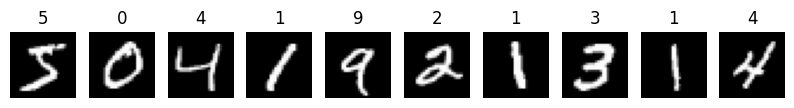

In [ ]:
import matplotlib.pyplot as plt

# Mostrar algunos ejemplos
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(str(train_labels[i]))
    plt.axis('off')
plt.show()


La visualización se puede hacer directamente con matplotlib. Mostramos 10 imágenes con sus etiquetas como título.

 Normalización y one-hot encoding

In [ ]:
import jax.numpy as jnp

def normalize_img(image, label):
    image = jnp.array(image) / 255.0
    label = jnp.eye(10)[label]  # one-hot encoding
    return image, label


Normalizamos los pixeles dividiendo por 255. El one-hot encoding se logra con jnp.eye(10)[label], que selecciona una fila de la identidad.

Función para preparar datos (batch, shuffle)

In [ ]:
import numpy as np

def data_load(images, labels, augmented=normalize_img, shuffle=True, batch_size=5):
    # Normalizamos y codificamos
    data = [augmented(img, lbl) for img, lbl in zip(images, labels)]

    if shuffle:
        np.random.shuffle(data)

    # Partimos en batches
    batches = [data[i:i+batch_size] for i in range(0, len(data), batch_size)]

    # Separar imágenes y etiquetas por batch
    return [(jnp.stack([x[0] for x in batch]), jnp.stack([x[1] for x in batch])) for batch in batches]


Esta función emula tf.data.Dataset con mapeo, shuffle y batching, todo en Python + JAX. Usamos listas y stack para empaquetar los batches.

 Preparar datasets

In [ ]:
data_train = data_load(train_images, train_labels)
data_test = data_load(test_images, test_labels, shuffle=False)


Visualizar algunos ejemplos del batch

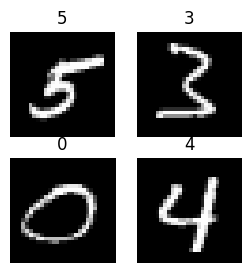

In [ ]:
plt.figure(figsize=(3, 3))
for i in range(4):
    images, labels = data_train[i]
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[0], cmap='gray')
    label_idx = jnp.argmax(labels[0])
    plt.title(f'{label_idx}')
    plt.axis('off')


Como data_train es una lista, simplemente indexamos y usamos argmax para obtener la clase a partir del one-hot encoding.

### Data Augmentation

### Metodo 1. sobre tf.data

In [ ]:
def augment_data(image, label):
    # Convertimos a NumPy en caso de que sea JAX array
    image = np.array(image)

    if np.random.rand() > 0.5:
        image = np.fliplr(image)
    if np.random.rand() > 0.5:
        image = np.flipud(image)
    if np.random.rand() > 0.5:
        # Especificamos los ejes (default es (0, 1) pero lo ponemos explícito)
        image = np.rot90(image, k=1, axes=(0, 1))

    return jnp.array(image), label


No hay funciones de imagen como en TensorFlow, así que usamos numpy para operaciones como flip y rot90. Esto se hace antes del entrenamiento.

Redefinir data_train y data_test con augmentación

In [ ]:
data_train = data_load(train_images, train_labels, augmented=augment_data)
data_test = data_load(test_images, test_labels, augmented=augment_data, shuffle=False)


Visualización de batches con .take()

(5, 28, 28) (5,)
(5, 28, 28) (5,)
(5, 28, 28) (5,)
(5, 28, 28) (5,)


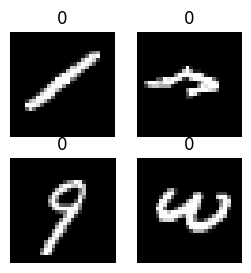

In [ ]:
plt.figure(figsize=(3, 3))
for i in range(4):
    images, labels = data_train[i]
    print(images.shape, labels.shape)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(np.array(images[0]), cmap='gray')
    label = jnp.argmax(labels[0])
    plt.title(f'{label}')
    plt.axis("off")


Usamos listas indexables en lugar de .take(), y argmax para recuperar la clase desde el one-hot encoding.

Secuencia de capas de augmentación con Keras

In [ ]:
import numpy as np
from jax.image import resize
from jax import random

def augment_pipeline(image, key):
    # Simula el Rescaling (aunque ya hecho antes)
    image = image / 255.0 if image.max() > 1 else image

    # Simula RandomContrast
    if random.uniform(key) > 0.5:
        factor = random.uniform(key, (), minval=0.5, maxval=1.5)
        mean = jnp.mean(image)
        image = (image - mean) * factor + mean

    # Simula RandomZoom
    if random.uniform(key) > 0.5:
        zoom = random.uniform(key, (), minval=0.8, maxval=1.2)
        new_size = int(image.shape[0] * zoom)
        image = resize(image, (new_size, new_size), method='bilinear')
        # Crop o pad al tamaño original
        if new_size > image.shape[0]:
            crop = (new_size - image.shape[0]) // 2
            image = image[crop:-crop, crop:-crop]
        else:
            pad = (image.shape[0] - new_size) // 2
            image = jnp.pad(image, ((pad, pad), (pad, pad)), mode='constant')

    # Simula RandomFlip
    if random.uniform(key) > 0.5:
        image = jnp.fliplr(image)

    # Simula RandomCrop a 20x20
    if image.shape[0] >= 20:
        start = random.randint(key, (), 0, image.shape[0] - 20)
        image = image[start:start+20, start:start+20]

    return image


Aquí implementamos transformaciones aleatorias como contraste, zoom, flip y crop usando jax.random para que sean compatibles con JAX.

CategoryEncoding (one-hot)

In [ ]:
label = jnp.eye(10)[label]


In [ ]:
def data_load_sequential(images, labels, augment_fn, batch_size=5, shuffle=True, rng_seed=0):
    from jax import random

    rng = random.PRNGKey(rng_seed)
    data = []

    for i in range(len(images)):
        key, rng = random.split(rng)
        img_aug = augment_fn(images[i], key)  # aplica augmentación tipo "modelo"
        lbl_onehot = jnp.eye(10)[labels[i]]
        data.append((img_aug, lbl_onehot))

    if shuffle:
        np.random.shuffle(data)

    # Particionar en batches
    batches = [data[i:i+batch_size] for i in range(0, len(data), batch_size)]

    # Formato final: lista de tuplas (batch_imgs, batch_labels)
    return [(jnp.stack([x[0] for x in batch]), jnp.stack([x[1] for x in batch])) for batch in batches]


Esta función replica el comportamiento de tf.data.Dataset.map + Sequential. Aquí usamos augment_pipeline como si fuera el modelo Keras y aplicamos jnp.eye para el one-hot. El uso de PRNGKey garantiza que las transformaciones sean reproducibles y compatibles con JAX

In [ ]:
plt.figure(figsize=(3, 3))
i=0
for ds,lb in data_train.take(4):
    print(ds.shape,lb)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(ds[0].numpy())
    shaped=ds[0].numpy().shape
    index = tf.argmax(lb, axis=1)
    plt.title('{}'.format(index[0].numpy()))
    plt.axis("off")
    i+=1

## Modelo

In [ ]:
!pip install flax


In [ ]:
import flax.linen as nn
import jax.numpy as jnp

class SimpleClassifier(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))  # Flatten batch of images
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x


Usamos @nn.compact para definir capas inline. La red toma un batch x, lo aplana (reshape), pasa por Dense(10) y termina con softmax.

Inicializar el modelo

In [ ]:
from flax.core import FrozenDict
import jax
import jax.random as random

model = SimpleClassifier()
key = random.PRNGKey(0)

# Simula un batch de entrada con 28x28 imágenes
sample_input = jnp.ones((1, 28, 28))
params = model.init(key, sample_input)  # Inicializa pesos


In [ ]:
logits = model.apply(params, sample_input)
print(logits)


[[0.01853871 0.02028864 0.01994409 0.04075364 0.06902275 0.06555992
  0.14929785 0.07925312 0.49320087 0.04414044]]


In [ ]:
import optax  # optimizador compatible con Flax

# Función de pérdida
def compute_loss(params, model, images, labels):
    logits = model.apply(params, images)
    one_hot = jax.nn.one_hot(labels, num_classes)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()
    return loss


# Función de accuracy
def compute_accuracy(params, model, images, labels):
    logits = model.apply(params, images)
    predictions = jnp.argmax(logits, axis=-1)
    acc = jnp.mean(predictions == labels)
    return acc


In [ ]:
import optax

learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


In [ ]:
def train_step(params, opt_state, model, images, labels):
    loss, grads = jax.value_and_grad(compute_loss)(params, model, images, labels)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss



In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    losses = []
    for batch_imgs, batch_lbls in data_train:
        params, opt_state, loss = train_step(params, opt_state, model, batch_imgs, batch_lbls)
        losses.append(loss)

    avg_loss = jnp.mean(jnp.stack(losses))
    acc = compute_accuracy(params, model, data_test[0][0], data_test[0][1])

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy (1st batch): {acc:.4f}")


Epoch 1, Loss: 1.9245, Accuracy (1st batch): 0.6000
Epoch 2, Loss: 1.8511, Accuracy (1st batch): 0.6000
Epoch 3, Loss: 1.8343, Accuracy (1st batch): 0.6000
Epoch 4, Loss: 1.8246, Accuracy (1st batch): 0.6000
